# BiLSTM 二分类模型训练

用于抗性基因(ARG)识别的二分类模型

**关键改进**:
1. 模型配置统一管理，保存时包含配置信息
2. 支持1:N比例采样阴性样本
3. 集成完整评估流程


In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import time
import random
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from Bio import SeqIO
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc)
from datetime import datetime


## 1. 配置参数

**重要**: 修改模型配置后，预测代码也需要同步修改！

In [2]:
# ================== 模型配置（预测时必须保持一致）==================
MODEL_CONFIG = {
    'vocab_size': 22,        # 20氨基酸 + X + PAD
    'embedding_dim': 48,     # Embedding维度（降低防过拟合）
    'hidden_size': 48,       # LSTM隐藏层维度（降低防过拟合）
    'num_layers': 1,         # LSTM层数（单层足够）
    'dropout': 0.5,          # Dropout比例
    'max_length': 1000,      # 序列最大长度
}

# ================== 训练配置 ==================
TRAIN_CONFIG = {
    'batch_size': 256,
    'lr': 0.001,             # 模型变小，学习率可稍高
    'weight_decay': 5e-3,    # 更强的L2正则化
    'epochs': 100,
    'patience': 15,          # 早停耐心值
    'pos_neg_ratio': 3,      # 阴性样本倍数
}

# ================== 路径配置（请修改为实际路径）==================
PATH_CONFIG = {
    'arg_file': "/home/mayue/model_c/data/ARG_db_all_seq_uniq_representative_rename_2_repsent.fasta",           # 阳性样本
    'non_arg_file': "/home/mayue/data/non_arg_lenmatch_r3_seed42.fasta",  # 阴性样本
    'save_dir': "./well-trained",
    'fig_dir': "./figures",
}

# 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 随机种子
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# 创建目录
for d in [PATH_CONFIG['save_dir'], PATH_CONFIG['fig_dir']]:
    os.makedirs(d, exist_ok=True)

# 日志（注意：在 Jupyter 环境里，logging.basicConfig 可能因为已存在 handler 而不生效，
# 导致 logger.info 不显示。这里显式配置一个独立 logger，保证训练日志可见且不重复。）
import sys

logger = logging.getLogger('binary_train')
logger.setLevel(logging.INFO)
logger.handlers.clear()
_h = logging.StreamHandler(sys.stdout)
_h.setFormatter(logging.Formatter("%(asctime)s - %(message)s"))
logger.addHandler(_h)
logger.propagate = False
logger.info('Logger initialized (binary_train).')


Using device: cuda:0
2026-02-06 14:21:58,772 - Logger initialized (binary_train).


## 2. 数据处理

In [3]:
# 氨基酸编码字典
AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'
AA_DICT = {aa: i + 1 for i, aa in enumerate(AMINO_ACIDS)}
AA_DICT.update({'X': 21, 'PAD': 0})

def seq_to_indices(sequence, max_length):
    """将氨基酸序列转换为索引数组"""
    indices = [AA_DICT.get(aa, 21) for aa in sequence]  # 未知氨基酸映射为X(21)
    indices = indices[:max_length]  # 截断
    if len(indices) < max_length:   # 填充
        indices += [0] * (max_length - len(indices))
    return np.array(indices, dtype=np.int64)


class FastaDataset(Dataset):
    """FASTA序列数据集"""
    def __init__(self, fasta_files, label, max_length, sample_n=None):
        """
        Args:
            fasta_files: FASTA文件路径列表
            label: 标签 (0 或 1)
            max_length: 序列最大长度
            sample_n: 随机采样数量（None表示全部使用）
        """
        self.sequences = []
        self.label = label
        self.max_length = max_length
        
        # 加载序列
        for f in fasta_files:
            for record in SeqIO.parse(f, "fasta"):
                self.sequences.append(str(record.seq).upper())
        
        # 随机采样
        if sample_n and sample_n < len(self.sequences):
            self.sequences = random.sample(self.sequences, sample_n)
        
        print(f"Loaded: label={label}, count={len(self.sequences)}")

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq_indices = seq_to_indices(self.sequences[idx], self.max_length)
        return torch.from_numpy(seq_indices), torch.tensor(self.label, dtype=torch.float32)


## 3. 模型定义

In [4]:
class BiLSTMModel(nn.Module):
    """BiLSTM + Global Pooling 二分类模型"""
    
    def __init__(self, config):
        super().__init__()
        self.embedding = nn.Embedding(
            config['vocab_size'], 
            config['embedding_dim'], 
            padding_idx=0
        )
        self.lstm = nn.LSTM(
            input_size=config['embedding_dim'],
            hidden_size=config['hidden_size'],
            num_layers=config['num_layers'],
            batch_first=True,
            bidirectional=True,
            dropout=config['dropout'] if config['num_layers'] > 1 else 0
        )
        self.dropout = nn.Dropout(config['dropout'])
        
        # 双向LSTM输出 * 2 (max + avg pooling) = hidden_size * 4
        self.classifier = nn.Sequential(
            nn.Linear(config['hidden_size'] * 4, config['hidden_size']),
            nn.ReLU(),
            nn.Dropout(config['dropout']),
            nn.Linear(config['hidden_size'], 1)
        )

    def forward(self, x):
        emb = self.embedding(x)          # (batch, seq_len, embed_dim)
        output, _ = self.lstm(emb)       # (batch, seq_len, hidden*2)
        
        # Global Pooling
        max_pool, _ = torch.max(output, dim=1)
        avg_pool = torch.mean(output, dim=1)
        features = torch.cat([max_pool, avg_pool], dim=1)  # (batch, hidden*4)
        
        return self.classifier(self.dropout(features))


## 4. 训练与评估函数

In [5]:
def train():
    # === 1. 加载数据 ===
    logger.info("Loading data...")
    
    # 加载阳性样本
    ds_pos = FastaDataset(
        [PATH_CONFIG['arg_file']], 
        label=1, 
        max_length=MODEL_CONFIG['max_length']
    )
    n_pos = len(ds_pos)
    
    # 加载阴性样本（按比例采样）
    n_neg_sample = n_pos * TRAIN_CONFIG['pos_neg_ratio']
    ds_neg = FastaDataset(
        [PATH_CONFIG['non_arg_file']], 
        label=0, 
        max_length=MODEL_CONFIG['max_length'],
        sample_n=n_neg_sample
    )
    
    # 合并数据集
    full_ds = ConcatDataset([ds_pos, ds_neg])
    labels_all = [1] * len(ds_pos) + [0] * len(ds_neg)
    
    # 分层划分训练集/验证集
    train_idx, val_idx = train_test_split(
        range(len(full_ds)), test_size=0.2, stratify=labels_all, random_state=42
    )
    
    train_loader = DataLoader(
        Subset(full_ds, train_idx), 
        batch_size=TRAIN_CONFIG['batch_size'],
        shuffle=True, num_workers=4, pin_memory=True
    )
    val_loader = DataLoader(
        Subset(full_ds, val_idx), 
        batch_size=TRAIN_CONFIG['batch_size'],
        shuffle=False, num_workers=4, pin_memory=True
    )
    
    # 计算类别权重
    train_labels = [labels_all[i] for i in train_idx]
    n_pos_train = sum(train_labels)
    n_neg_train = len(train_labels) - n_pos_train
    pos_weight = torch.tensor(n_neg_train / n_pos_train, dtype=torch.float32).to(device)
    logger.info(f"Train: Pos={n_pos_train}, Neg={n_neg_train}, pos_weight={pos_weight.item():.2f}")
    
    # === 2. 构建模型 ===
    model = BiLSTMModel(MODEL_CONFIG).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.AdamW(model.parameters(), lr=TRAIN_CONFIG['lr'], weight_decay=TRAIN_CONFIG['weight_decay'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)  # 监控val_loss
    
    # === 3. 训练循环 ===
    best_loss = float('inf')  # 改为监控验证loss
    patience_cnt = 0
    history = {'train_loss': [], 'val_loss': [], 'val_auc': [], 'val_f1': []}
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M')
    save_path = os.path.join(PATH_CONFIG['save_dir'], f"bilstm_{timestamp}.pth")
    
    logger.info(f"Start training for {TRAIN_CONFIG['epochs']} epochs...")
    
    for epoch in range(TRAIN_CONFIG['epochs']):
        start_time = time.time()
        
        # --- Train ---
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.unsqueeze(1).to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
        
        # --- Validate ---
        model.eval()
        val_loss = 0
        y_true, y_probs = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.unsqueeze(1).to(device)
                logits = model(x)
                val_loss += criterion(logits, y).item()
                probs = torch.sigmoid(logits).cpu().numpy()
                y_true.extend(y.cpu().numpy())
                y_probs.extend(probs)
        
        # --- Metrics ---
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        y_true = np.array(y_true).flatten()
        y_probs = np.array(y_probs).flatten()
        y_pred = (y_probs > 0.5).astype(int)
        
        val_auc = roc_auc_score(y_true, y_probs)
        val_f1 = f1_score(y_true, y_pred)
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_auc'].append(val_auc)
        history['val_f1'].append(val_f1)
        
        logger.info(
            f"Epoch {epoch+1:03d} | Loss: {avg_train_loss:.4f}/{avg_val_loss:.4f} | "
            f"AUC: {val_auc:.4f} | F1: {val_f1:.4f} | Time: {time.time()-start_time:.1f}s"
        )
        
        scheduler.step(avg_val_loss)  # 监控验证loss
        
        # --- Early Stopping (基于验证loss，防止过拟合) ---
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_auc = val_auc  # 记录对应的AUC
            torch.save({
                'model_state_dict': model.state_dict(),
                'config': MODEL_CONFIG,
            }, save_path)
            patience_cnt = 0
            logger.info(f"  -> Best model saved! (Loss: {best_loss:.4f}, AUC: {val_auc:.4f})")
        else:
            patience_cnt += 1
            if patience_cnt >= TRAIN_CONFIG['patience']:
                logger.info("Early stopping triggered.")
                break
    
    # === 4. 最终评估 ===
    evaluate_and_plot(save_path, val_loader, history)
    return save_path


In [6]:
def evaluate_and_plot(model_path, dataloader, history):
    """加载最佳模型进行评估并绘制图表"""
    logger.info("Running final evaluation...")
    
    # 加载模型
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    model = BiLSTMModel(checkpoint['config']).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # 预测
    y_true, y_probs = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            logits = model(x)
            y_true.extend(y.numpy())
            y_probs.extend(torch.sigmoid(logits).cpu().numpy())
    
    y_true = np.array(y_true)
    y_probs = np.array(y_probs).flatten()
    y_pred = (y_probs > 0.5).astype(int)
    
    # 打印指标
    print("\n" + "=" * 50)
    print("EVALUATION REPORT")
    print("=" * 50)
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred):.4f}")
    print(f"ROC AUC:   {roc_auc_score(y_true, y_probs):.4f}")
    print(f"\nConfusion Matrix:\n{confusion_matrix(y_true, y_pred)}")
    print("=" * 50)
    
    # 绘图
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Loss曲线
    axes[0].plot(history['train_loss'], label='Train')
    axes[0].plot(history['val_loss'], label='Val')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss Curve')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # ROC曲线
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc_val = roc_auc_score(y_true, y_probs)
    axes[1].plot(fpr, tpr, label=f'AUC = {roc_auc_val:.3f}')
    axes[1].plot([0, 1], [0, 1], 'r--')
    axes[1].set_xlabel('FPR')
    axes[1].set_ylabel('TPR')
    axes[1].set_title('ROC Curve')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # PR曲线
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_probs)
    pr_auc = auc(recall_vals, precision_vals)
    axes[2].plot(recall_vals, precision_vals, label=f'AUC = {pr_auc:.3f}')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].set_title('PR Curve')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(PATH_CONFIG['fig_dir'], 'training_results.png'), dpi=300)
    plt.savefig(os.path.join(PATH_CONFIG['fig_dir'], 'training_results.pdf'))
    plt.show()
    
    logger.info(f"Figures saved to {PATH_CONFIG['fig_dir']}")


## 5. 开始训练

2026-02-06 14:21:58,838 - Loading data...
Loaded: label=1, count=17345
Loaded: label=0, count=52035
2026-02-06 14:21:59,660 - Train: Pos=13876, Neg=41628, pos_weight=3.00
2026-02-06 14:22:07,398 - Start training for 100 epochs...
2026-02-06 14:22:12,751 - Epoch 001 | Loss: 0.6075/0.4379 | AUC: 0.9682 | F1: 0.8320 | Time: 5.4s
2026-02-06 14:22:12,761 -   -> Best model saved! (Loss: 0.4379, AUC: 0.9682)
2026-02-06 14:22:17,831 - Epoch 002 | Loss: 0.3576/0.2713 | AUC: 0.9807 | F1: 0.8528 | Time: 5.1s
2026-02-06 14:22:17,881 -   -> Best model saved! (Loss: 0.2713, AUC: 0.9807)
2026-02-06 14:22:22,942 - Epoch 003 | Loss: 0.3222/0.2468 | AUC: 0.9836 | F1: 0.8668 | Time: 5.1s
2026-02-06 14:22:22,950 -   -> Best model saved! (Loss: 0.2468, AUC: 0.9836)
2026-02-06 14:22:28,033 - Epoch 004 | Loss: 0.2865/0.2369 | AUC: 0.9863 | F1: 0.9024 | Time: 5.1s
2026-02-06 14:22:28,043 -   -> Best model saved! (Loss: 0.2369, AUC: 0.9863)
2026-02-06 14:22:33,045 - Epoch 005 | Loss: 0.2541/0.2164 | AUC: 0.987

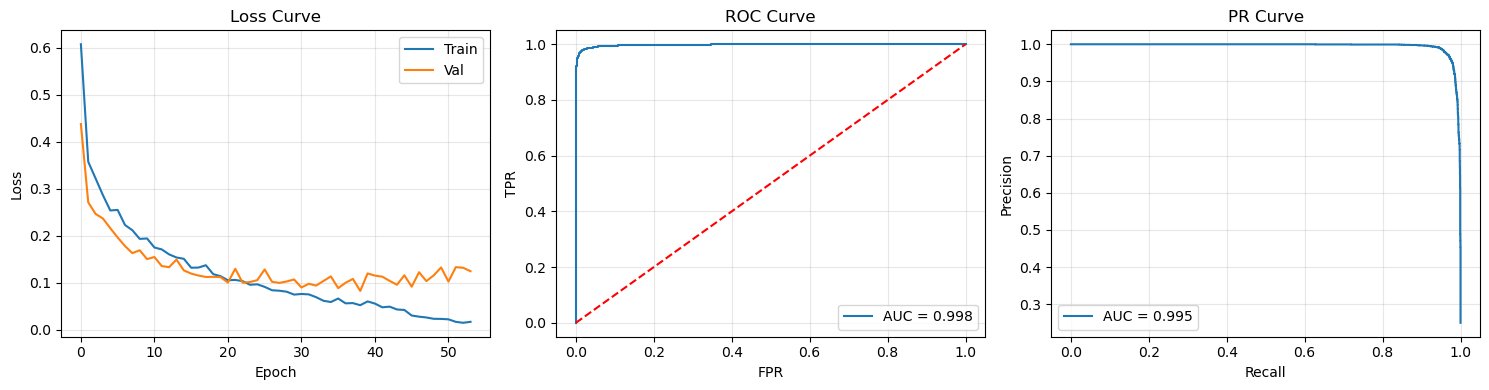

2026-02-06 14:26:43,457 - Figures saved to ./figures

Model saved to: ./well-trained/bilstm_20260206_1422.pth


In [7]:
# 运行训练
model_path = train()
print(f"\nModel saved to: {model_path}")
